In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import statsmodels.api as sm
import scipy.stats as stats


data_dir = '../data/'

               real  nominal
Date                        
1915-01-01  1723.00    56.54
1915-02-01  1693.46    55.02
                real   nominal
Date                          
2023-10-01  33052.87  33052.87
2023-11-01  34337.87  34337.87


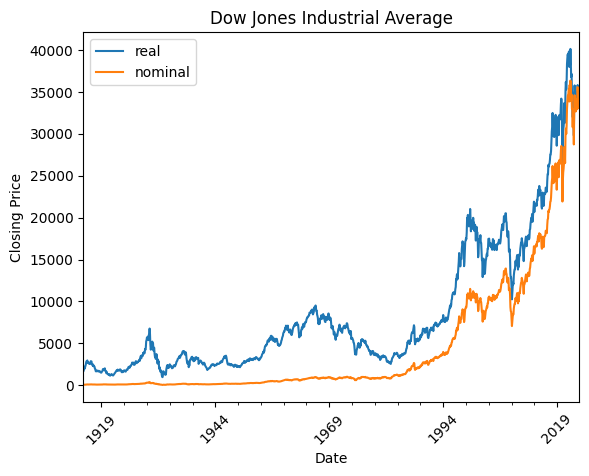

In [2]:
# load stock_data.csv
stock_data = pd.read_csv(data_dir + 'stock_data.csv')
stock_data.set_index('date', inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)
stock_data.index.name = 'Date'

# plot
stock_data.plot()
plt.xticks(rotation=45)
plt.title('Dow Jones Industrial Average')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# print head and plot
print(stock_data.head(2))
print(stock_data.tail(2))


In [3]:
# load in CPI data from database
conn = sqlite3.connect('../food_inflation_analysis.db')
query = '''SELECT * FROM OCED_USA_FOOD_INFLATION'''
cpi_food_data = pd.read_sql(query, conn)
cpi_food_data.set_index('Date', inplace=True)
cpi_food_data.index = pd.to_datetime(cpi_food_data.index)
print(cpi_food_data.head(2))
# close connection
conn.close()


                 CPI  CPI_lag_1  CPI_lag_2  CPI_lag_3  CPI_lag_4  CPI_lag_5  \
Date                                                                          
1956-01-01 -1.700680        NaN        NaN        NaN        NaN        NaN   
1956-02-01 -2.372881   -1.70068        NaN        NaN        NaN        NaN   

            CPI_lag_6  
Date                   
1956-01-01        NaN  
1956-02-01        NaN  


In [4]:
# find correlation between stock_data and cpi_food_data
# merge stock_data and cpi_food_data
stock_cpi_merge = pd.merge(stock_data, cpi_food_data, how='inner', on='Date')
print(stock_cpi_merge.head(2))

# add column for lags of stock_data
stock_cpi_merge['real_lag1'] = stock_cpi_merge['real'].shift(1)
stock_cpi_merge['nominal_lag1'] = stock_cpi_merge['nominal'].shift(1)
print(stock_cpi_merge.head(2))

               real  nominal       CPI  CPI_lag_1  CPI_lag_2  CPI_lag_3  \
Date                                                                      
1956-01-01  5406.45   470.74 -1.700680        NaN        NaN        NaN   
1956-02-01  5554.72   483.65 -2.372881   -1.70068        NaN        NaN   

            CPI_lag_4  CPI_lag_5  CPI_lag_6  
Date                                         
1956-01-01        NaN        NaN        NaN  
1956-02-01        NaN        NaN        NaN  
               real  nominal       CPI  CPI_lag_1  CPI_lag_2  CPI_lag_3  \
Date                                                                      
1956-01-01  5406.45   470.74 -1.700680        NaN        NaN        NaN   
1956-02-01  5554.72   483.65 -2.372881   -1.70068        NaN        NaN   

            CPI_lag_4  CPI_lag_5  CPI_lag_6  real_lag1  nominal_lag1  
Date                                                                  
1956-01-01        NaN        NaN        NaN        NaN           NaN  
1

In [5]:
# drop NaN values then calculate correlation between real_lag1, nominal_lag1 with CPI
stock_cpi_merge.dropna(inplace=True)

# calculate correlation using Spearman correlation
corr_real = stock_cpi_merge['real_lag1'].corr(stock_cpi_merge['CPI'], method='spearman')
corr_nominal = stock_cpi_merge['nominal_lag1'].corr(stock_cpi_merge['CPI'], method='spearman')
stock_cpi_merge['ratio'] = stock_cpi_merge['real_lag1'] / stock_cpi_merge['nominal_lag1']
corr_ratio = stock_cpi_merge['ratio'].corr(stock_cpi_merge['CPI'], method='spearman')
print('Correlation between Dow Jones ratio of real_lag1 and nominal_lag1 and CPI: ', corr_ratio)
print('Correlation between Dow Jones real lag 1 and CPI: ', corr_real)
print('Correlation between Dow Jones nominal lag 1 and CPI: ', corr_nominal)

Correlation between Dow Jones ratio of real_lag1 and nominal_lag1 and CPI:  0.1093202316447041
Correlation between Dow Jones real lag 1 and CPI:  -0.3163731417133973
Correlation between Dow Jones nominal lag 1 and CPI:  -0.1609096434661088


In [6]:
# using OLS to find statistical significance of these correlations
# get confidence intervals for real_lag1
real_lag1 = stock_cpi_merge['real_lag1']
real_lag1 = sm.add_constant(real_lag1)
model = sm.OLS(stock_cpi_merge['CPI'], real_lag1)
results = model.fit()
print(results.summary())

# get confidence intervals for nominal_lag1
nominal_lag1 = stock_cpi_merge['nominal_lag1']
nominal_lag1 = sm.add_constant(nominal_lag1)
model = sm.OLS(stock_cpi_merge['CPI'], nominal_lag1)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     23.77
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           1.31e-06
Time:                        22:48:50   Log-Likelihood:                -2197.0
No. Observations:                 807   AIC:                             4398.
Df Residuals:                     805   BIC:                             4407.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4591      0.220     20.228      0.0

In [7]:
# Analyze lag correlations
lag = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
corrs = []
for i in lag:
    corr = stock_cpi_merge['real'].shift(i).corr(stock_cpi_merge['CPI'], method='spearman')
    corrs.append(corr)
    print(f'Correlation between dow jones stock price and food inflation with lag {i}: ', corr)
    # get the number of observations
    n = len(stock_cpi_merge['real'].shift(i))

    # get the t critical value
    t_crit = stats.t.ppf(0.975, n-2)

    # get the standard error
    se = np.sqrt((1-corr**2)/(n-2))

    # get the margin of error
    moe = t_crit*se

    # get the confidence interval
    ci = (corr-moe, corr+moe)

    # print('Confidence interval for the correlation: ', ci)

Correlation between dow jones stock price and food inflation with lag 1:  -0.3167522882129714
Correlation between dow jones stock price and food inflation with lag 2:  -0.30913340331941835
Correlation between dow jones stock price and food inflation with lag 3:  -0.30231865481994025
Correlation between dow jones stock price and food inflation with lag 4:  -0.29423893105205384
Correlation between dow jones stock price and food inflation with lag 5:  -0.28592821902029464
Correlation between dow jones stock price and food inflation with lag 6:  -0.2765346467240428
Correlation between dow jones stock price and food inflation with lag 7:  -0.2669546353419457
Correlation between dow jones stock price and food inflation with lag 8:  -0.25824547633161016
Correlation between dow jones stock price and food inflation with lag 9:  -0.25046039763313876
Correlation between dow jones stock price and food inflation with lag 10:  -0.24172966192580456
Correlation between dow jones stock price and food i

Text(0, 0.5, 'Correlation')

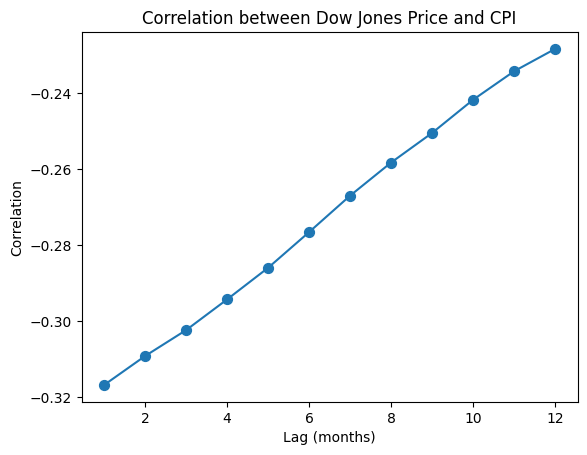

In [8]:
# plot the correlation between Dow Jones and CPI with lag
plt.plot(lag, corrs)
plt.scatter(lag, corrs, s=50)
plt.title('Correlation between Dow Jones Price and CPI')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')

In [38]:
# create dataframe with lags 1-4
stock_df_lag = pd.DataFrame()
stock_df_lag['stock_value'] = stock_data['real']
# add lags
for i in range(1, 5):
    stock_df_lag[f'stock_value_lag_{i}'] = stock_df_lag['stock_value'].shift(i)

# print
print(stock_df_lag.head(5))


            stock_value  stock_value_lag_1  stock_value_lag_2  \
Date                                                            
1915-01-01      1723.00                NaN                NaN   
1915-02-01      1693.46            1723.00                NaN   
1915-03-01      1891.20            1693.46            1723.00   
1915-04-01      2209.32            1891.20            1693.46   
1915-05-01      1981.11            2209.32            1891.20   

            stock_value_lag_3  stock_value_lag_4  
Date                                              
1915-01-01                NaN                NaN  
1915-02-01                NaN                NaN  
1915-03-01                NaN                NaN  
1915-04-01            1723.00                NaN  
1915-05-01            1693.46             1723.0  


In [39]:
# save this dataframe to the database
conn = sqlite3.connect('../food_inflation_analysis.db')
# save dataframe to database
stock_df_lag.to_sql('DOW_JONES_REAL', conn, if_exists='replace', index=True)

# print table names
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

# close connection
conn.close()

[('OCED_USA_FOOD_INFLATION',), ('USA_MEAT_EXPORT_IMPORT',), ('interest_rate',), ('food_production',), ('gas_prices',), ('DOW_JONES_REAL',)]
